# Unsynchronized Reprogramming

**Summary** This dataset contains population RNAseq collected throughout time during a recreation of Weintraub's reprogramming experiment.

**Reference**: [Genome Architecture Mediates Transcriptional
Control of Human Myogenic Reprogramming](https://drive.google.com/file/d/1VV7y59NuTpO7lHVsktjxcew1p4yfvIbB/view)

In [1]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import anndata as ad
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [2]:
DATAPATH = "/nfs/turbo/umms-indikar/shared/projects/foundation_models/experiments/populationReprogramming/"
MODELS   = [
    "tGPT",
    "geneformer",
    "scgpt",
    "raw"
]
ads = {}
for model in MODELS:
    ads[model] = ad.read_h5ad(os.path.join(DATAPATH, model + '.h5ad'))

## Scree Plots

In [3]:
svs = []
for key, adata in ads.items():
    print(key)
    X = np.nan_to_num(adata.X, nan=0.0)
    _, sigma, _ = np.linalg.svd(X)
    svs.append(sigma)

tGPT
geneformer
scgpt
raw


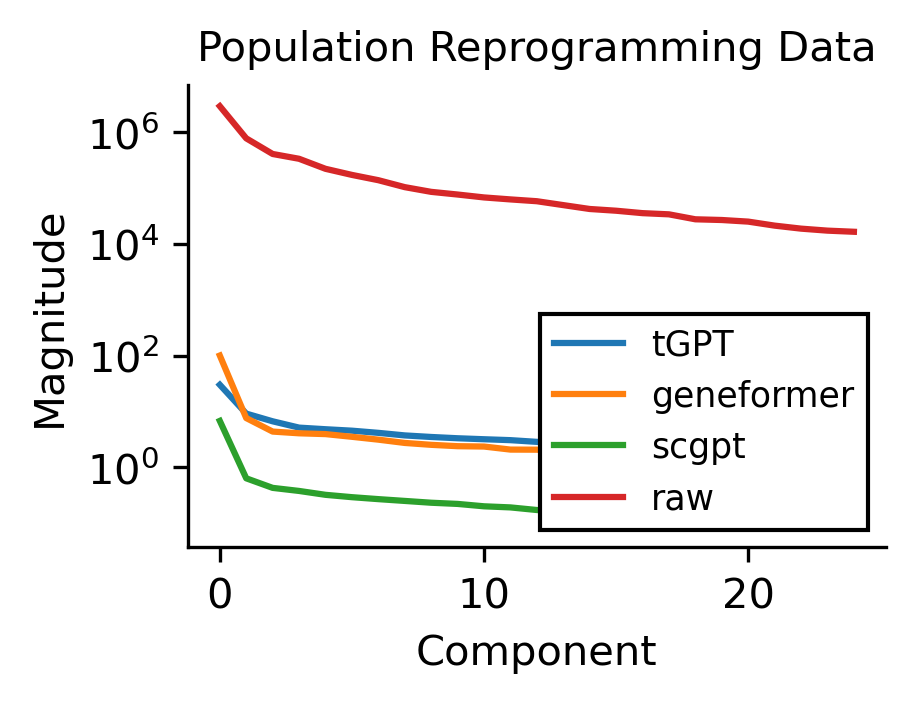

In [4]:
plt.figure(figsize=(3,2), dpi=300)
for i in range(4):
    # n = svs[i] / sum(svs[i])
    n = svs[i]
    plt.plot(n[:25], label=list(ads.keys())[i])
plt.legend(loc='lower right', fontsize='small', fancybox=False, framealpha=1, edgecolor='black')
sns.despine()
plt.xlabel('Component')
plt.ylabel('Magnitude')
plt.yscale('log')
plt.title('Population Reprogramming Data', fontsize=10)
plt.show()

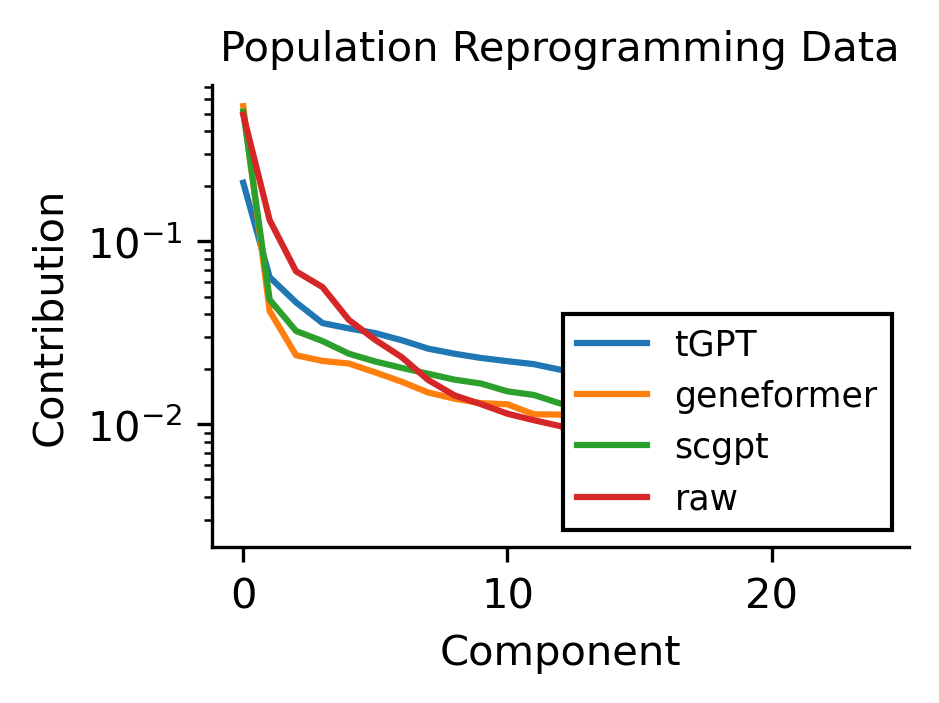

In [5]:
plt.figure(figsize=(3,2), dpi=300)
for i in range(4):
    n = svs[i] / sum(svs[i])
    # n = svs[i]
    plt.plot(n[:25], label=list(ads.keys())[i])
plt.legend(loc='lower right', fontsize='small', fancybox=False, framealpha=1, edgecolor='black')
sns.despine()
plt.xlabel('Component')
plt.ylabel('Contribution')
plt.yscale('log')
plt.title('Population Reprogramming Data', fontsize=10)
plt.show()


## Building DMD Models

In [4]:
from pydmd import DMD
from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

def anndata2timeseries(adata):
    """converts an ann data object to a tensor that we can perform DMD on"""
    replicates = adata.obs['replicate'].nunique()
    maxTimePts = adata.obs['order'].nunique()
    offsetRep, offsetTime = 0, 0
    if adata.obs['replicate'].min() == 1:
        offsetRep = 1
    if adata.obs['order'].min() == 1:
        offsetTime = 1
    stateDims  = adata.X.shape[1]
    X = np.zeros((stateDims, maxTimePts, replicates))
    for observation in range(adata.X.shape[0]):
        rep  = adata.obs['replicate'].iloc[observation] - offsetRep
        time = adata.obs['order'].iloc[observation] - offsetTime
        X[:, time, rep] = adata.X[observation, :]
    return X

def tensor2matrices(data):
    """
    Utility function to reshape the data for Dynamic Mode Decomposition (DMD).

    Params:
    --------------
    data (np.array):
        An array of shape (genes, timepoints, replicates).

    Returns:
    --------------
    Xp (np.array):
        The first m-1 timepoints for all replicates.

    Xf (np.array):
        The last m-1 timepoints for all replicates.
    """
    if data.ndim == 2:
        data = data[:, :, np.newaxis]

    n, m, r = data.shape

    Xp = data[:,:-1].reshape(n, (m-1)*r, order='F')
    Xf = data[:,1:].reshape(n, (m-1)*r, order='F')

    return Xp, Xf


In [5]:
dmdR, dmdG, dmdT, dmdS = DMD(), DMD(), DMD(), DMD()
Xm, Xp = tensor2matrices(anndata2timeseries(ads['raw']))
dmdR.fit(Xm, Xp)
Xm, Xp = tensor2matrices(anndata2timeseries(ads['geneformer']))
dmdG.fit(Xm, Xp)
Xm, Xp = tensor2matrices(anndata2timeseries(ads['tGPT']))
dmdT.fit(Xm, Xp)
Xm, Xp = tensor2matrices(anndata2timeseries(ads['scgpt']))
dmdS.fit(Xm, Xp)

In [6]:
dmdR.reconstructed_data.real.shape

(19393, 45)

In [7]:
Xp.shape

(512, 45)

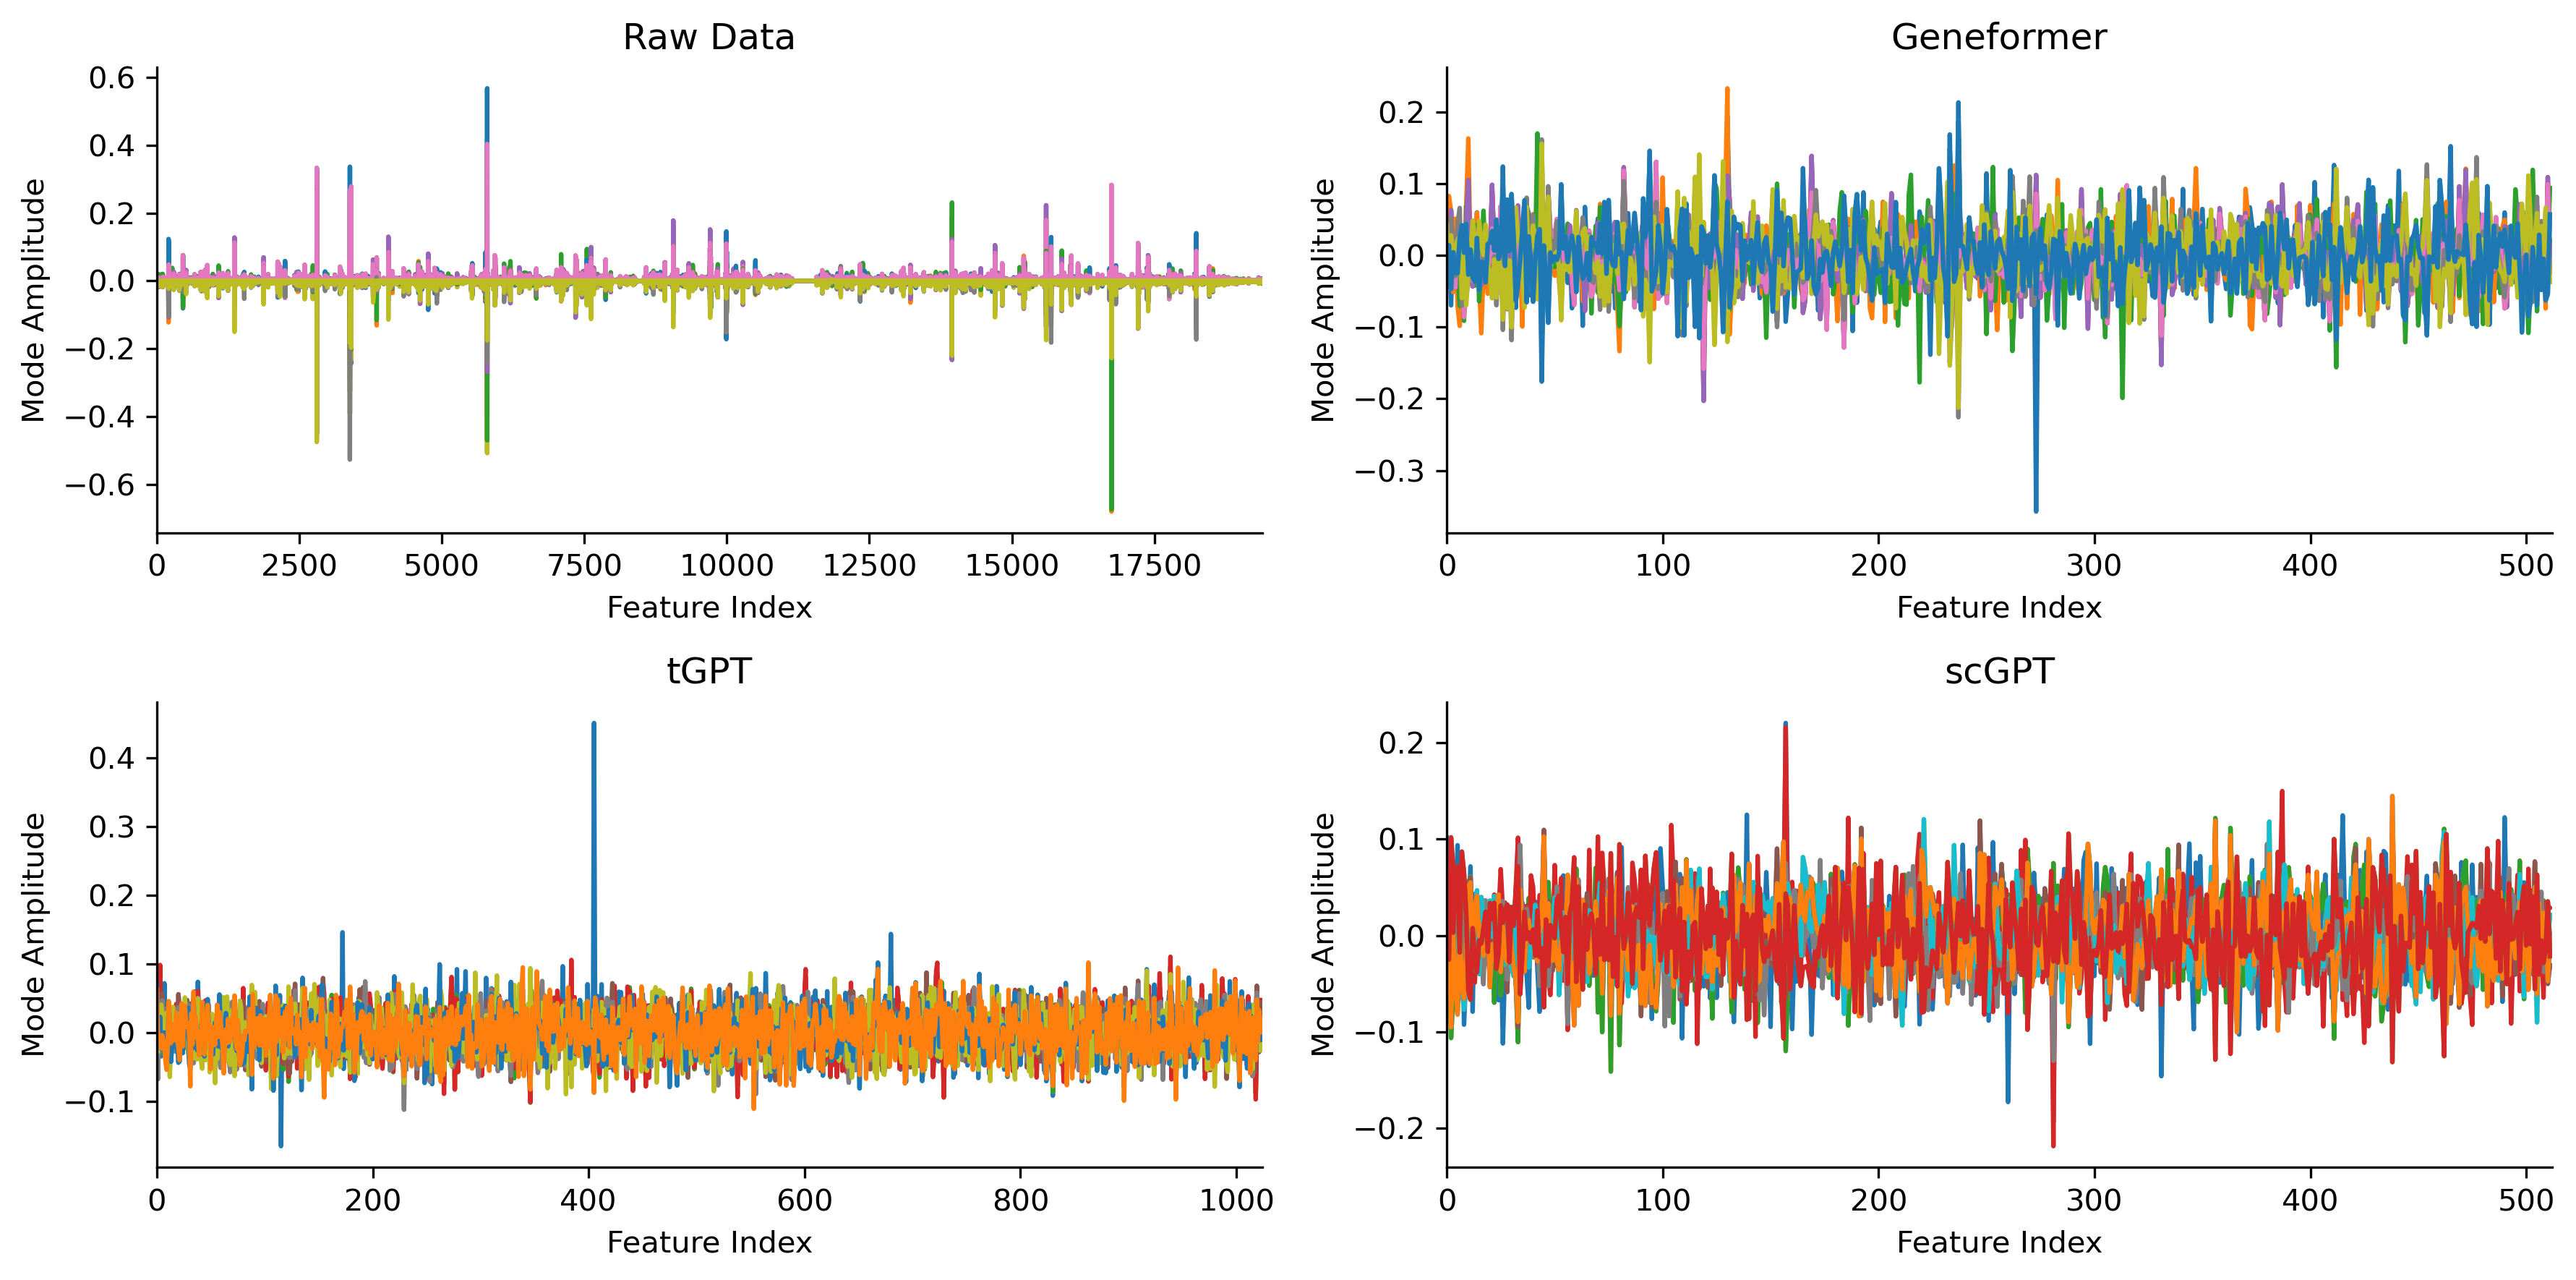

In [10]:
dmd_models = [dmdR, dmdG, dmdT, dmdS]
labels = ['Raw Data', 'Geneformer', 'tGPT', 'scGPT']

plt.figure(figsize=(12, 6), dpi=300)

for i, (dmd, label) in enumerate(zip(dmd_models, labels)):
    plt.subplot(2, 2, i+1)
    for mode in dmd.modes.T:
        plt.plot(mode.real)
    plt.title(f'{label}')
    plt.xlabel('Feature Index')
    plt.ylabel('Mode Amplitude')
    plt.xlim([0, len(mode)])
    sns.despine()
    
plt.tight_layout()
plt.show()


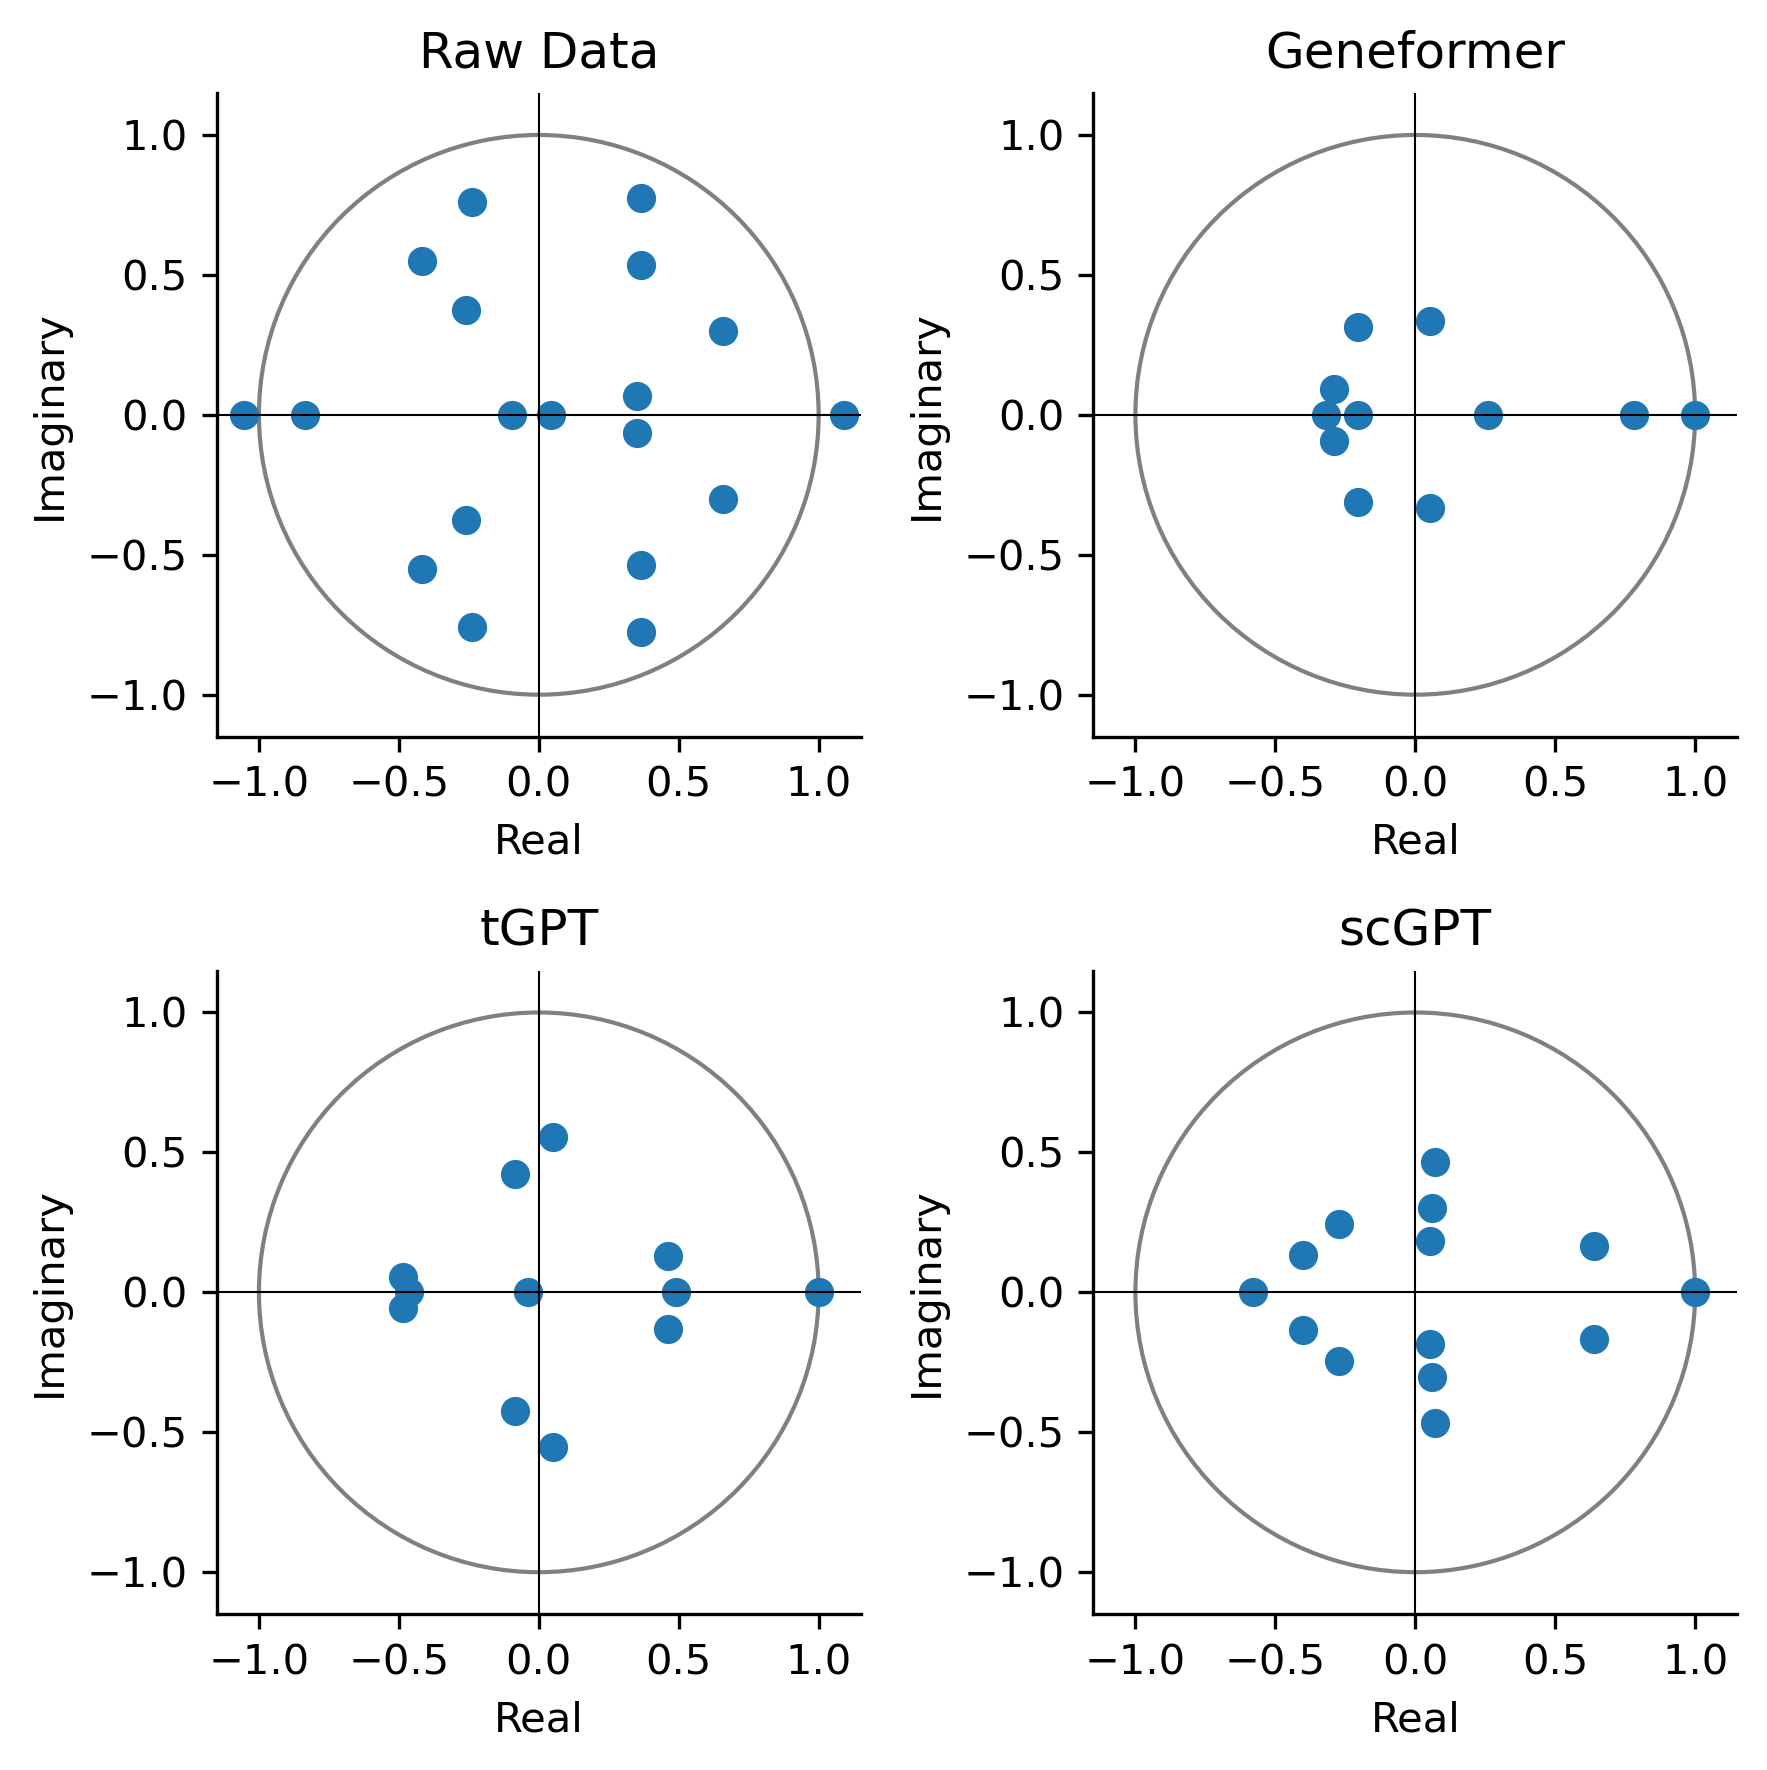

In [11]:
dmd_models = [dmdR, dmdG, dmdT, dmdS]
labels = ['Raw Data', 'Geneformer', 'tGPT', 'scGPT']

# Create a figure
plt.figure(figsize=(6, 6), dpi=300)

for i, (dmd, label) in enumerate(zip(dmd_models, labels)):
    plt.subplot(2, 2, i + 1)
    eigenvalues = dmd.eigs
    
    # Plot the unit circle
    unit_circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='-')
    plt.gca().add_artist(unit_circle)
    
    # Plot the eigenvalues
    plt.scatter(eigenvalues.real, eigenvalues.imag, marker='o', label='Eigenvalues')
    
    plt.title(label)
    plt.xlabel('Real')
    plt.ylabel('Imaginary')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    sns.despine()
    plt.xlim([-1.15, 1.15])
    plt.ylim([-1.15, 1.15])

plt.tight_layout()
plt.show()


NameError: name 'mode_colors' is not defined

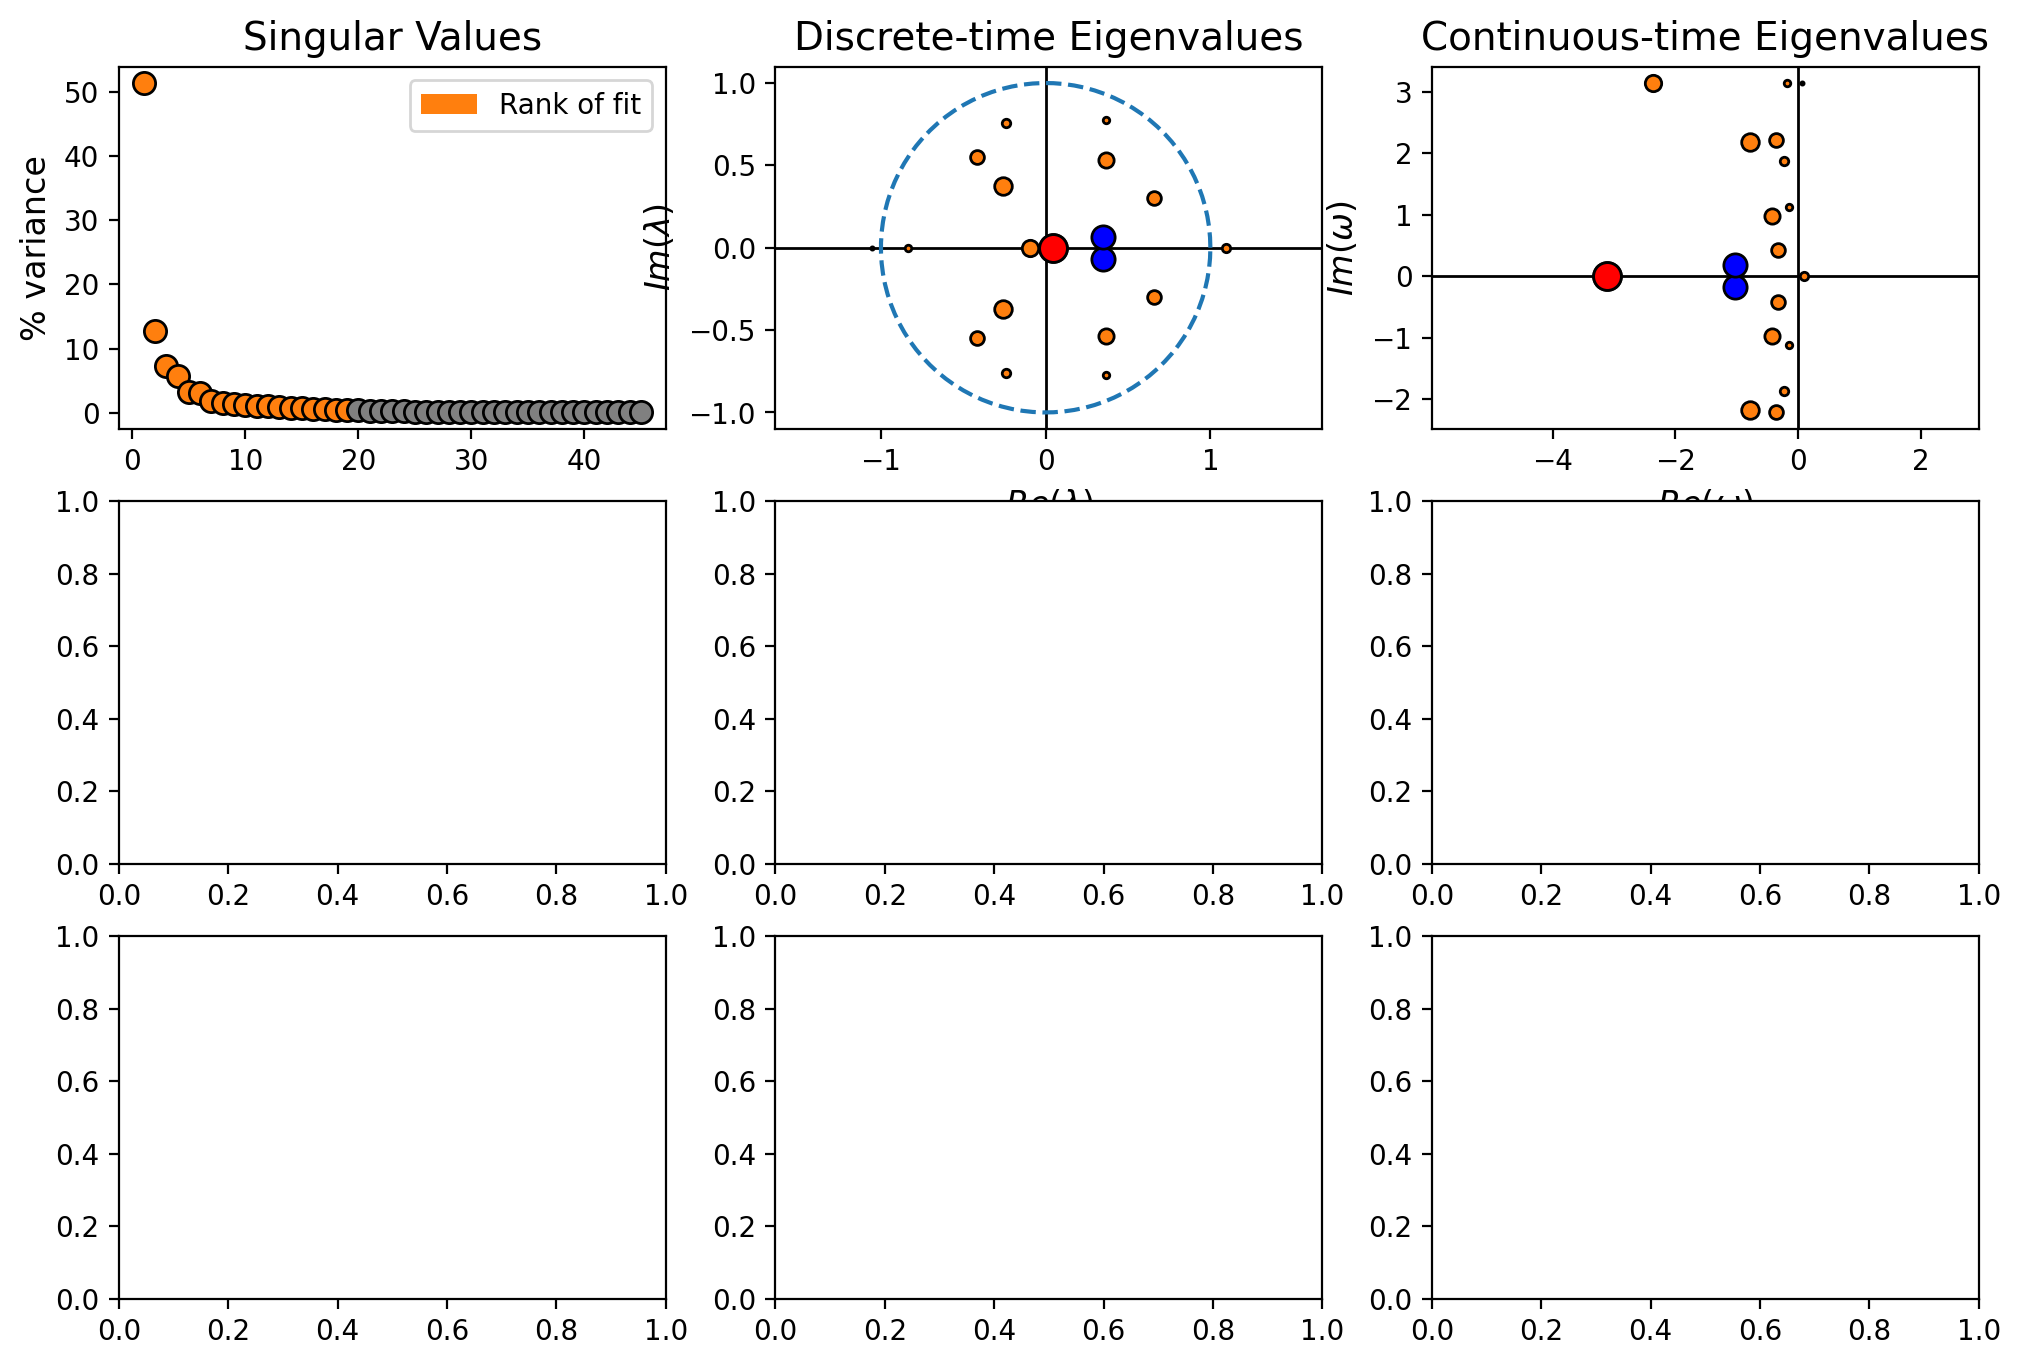

In [8]:
plot_summary(dmdR)

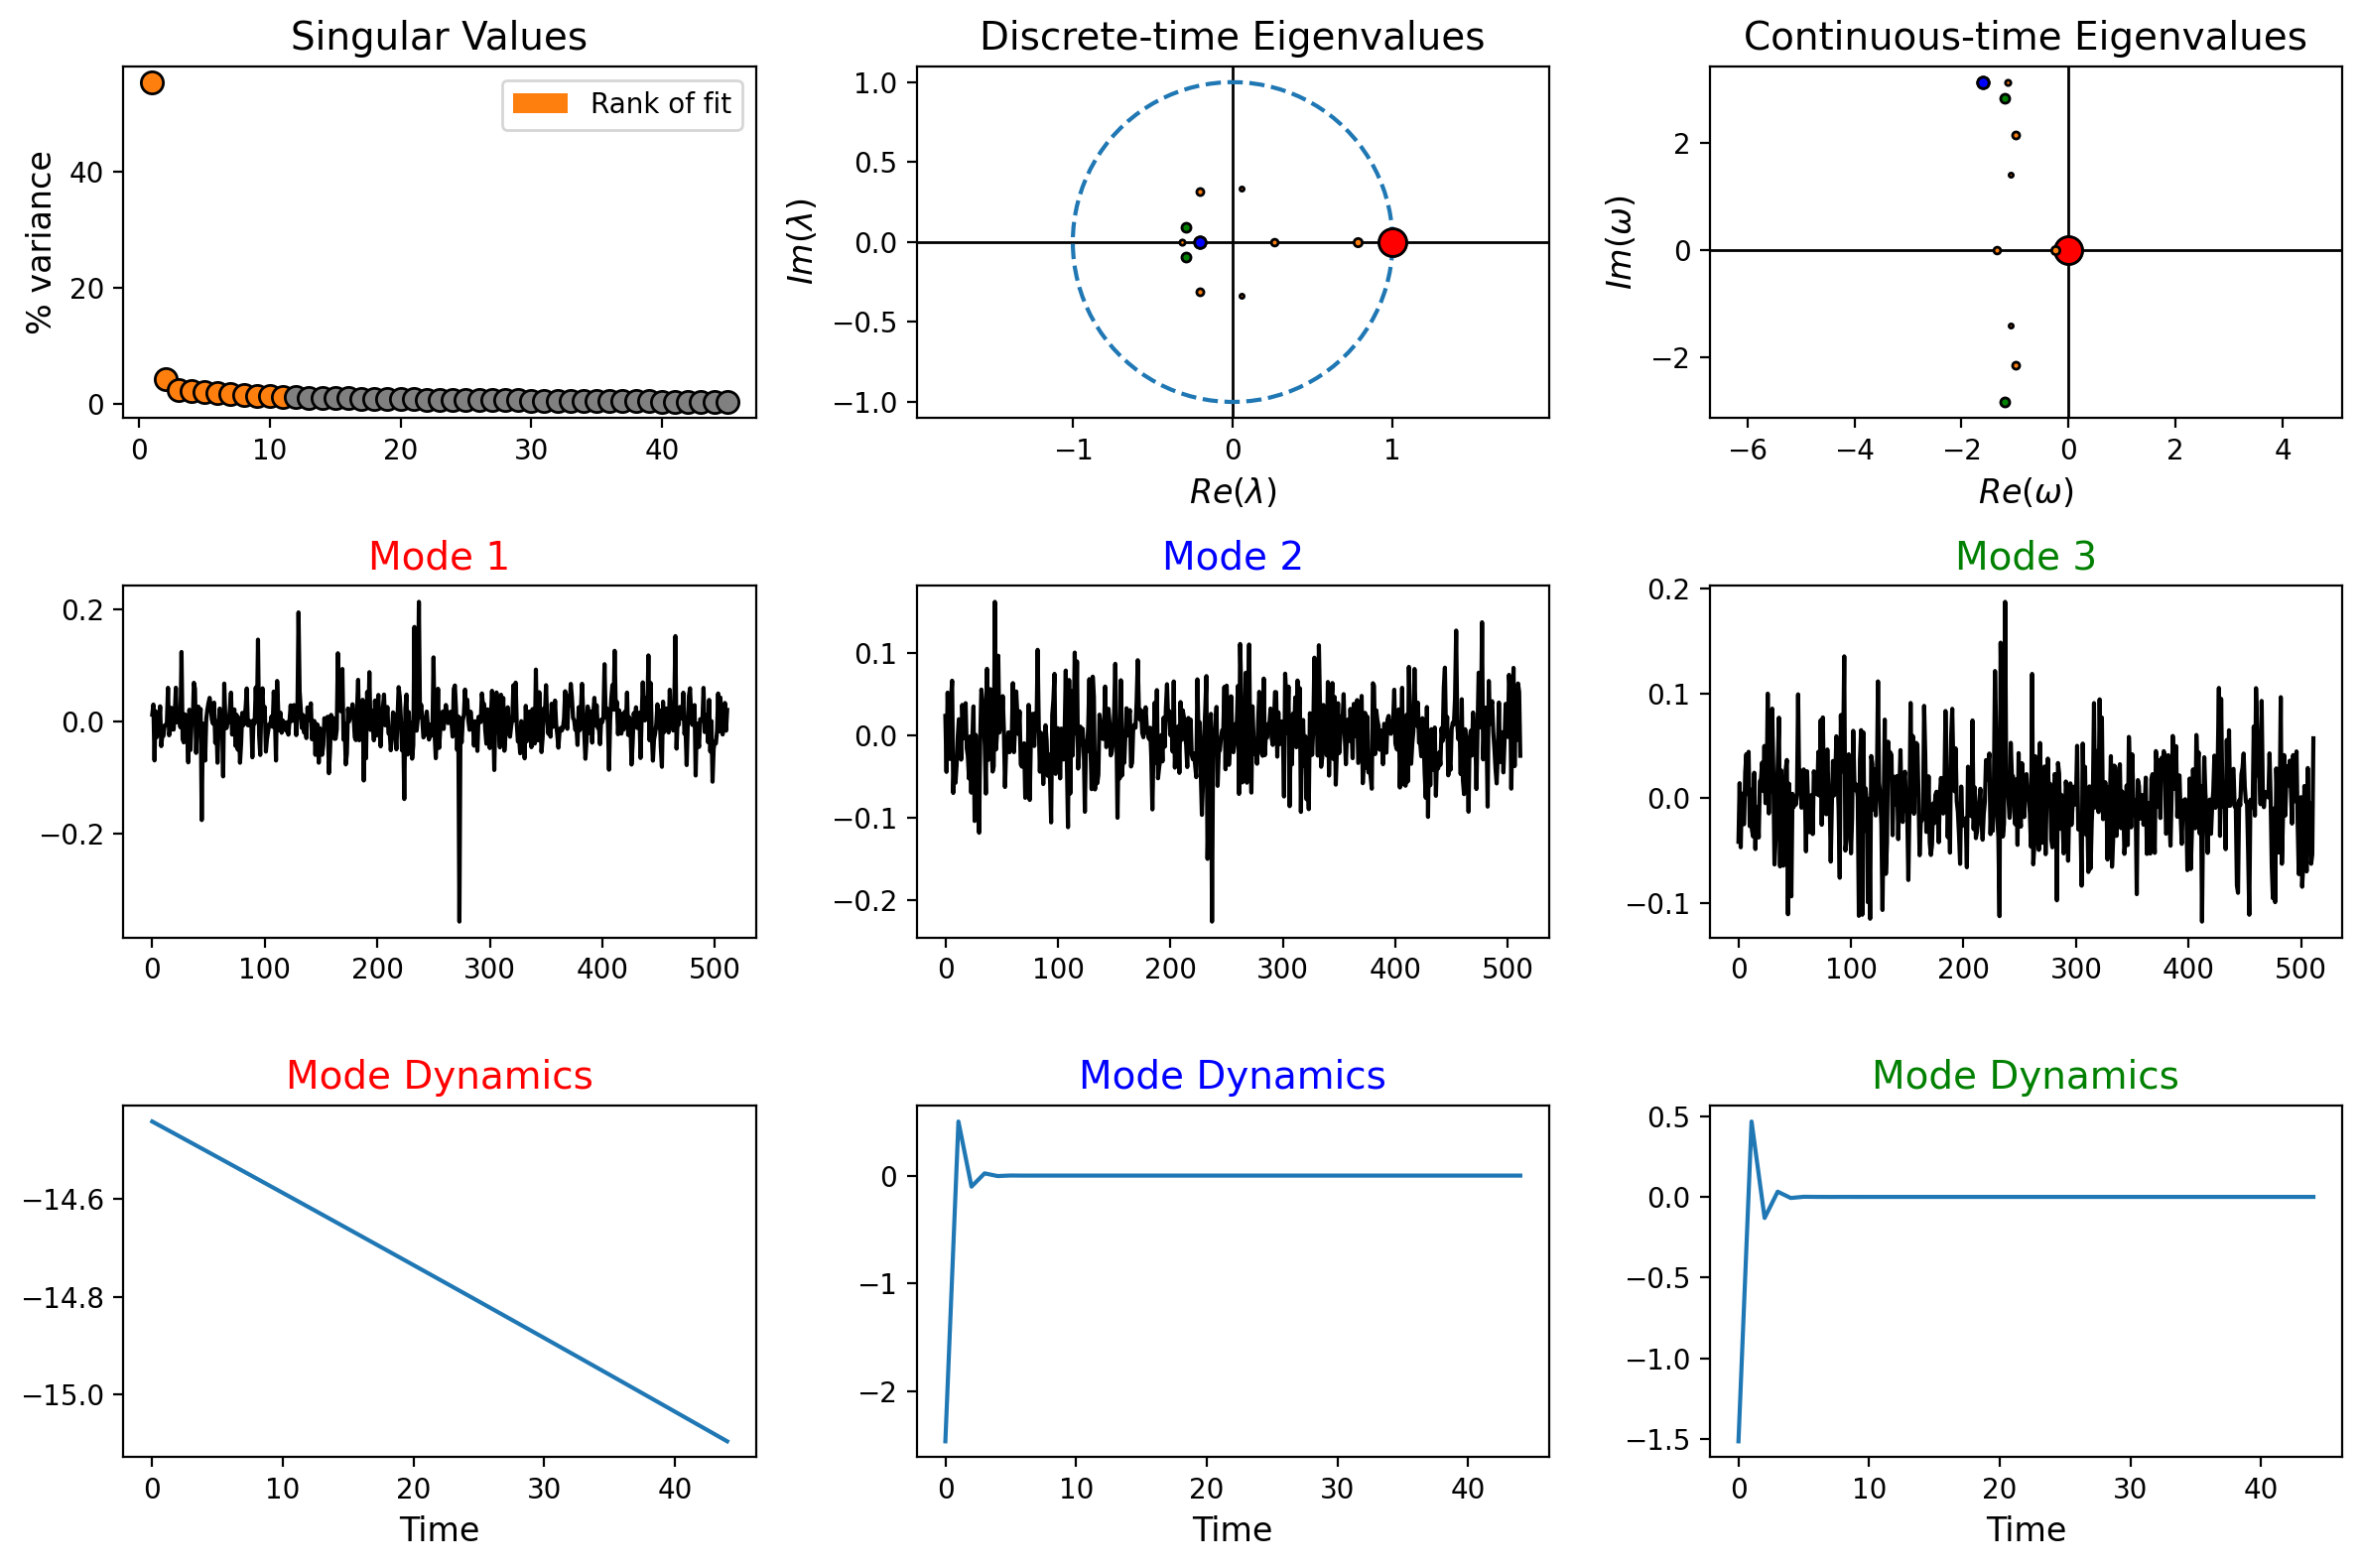

In [15]:
plot_summary(dmdG)

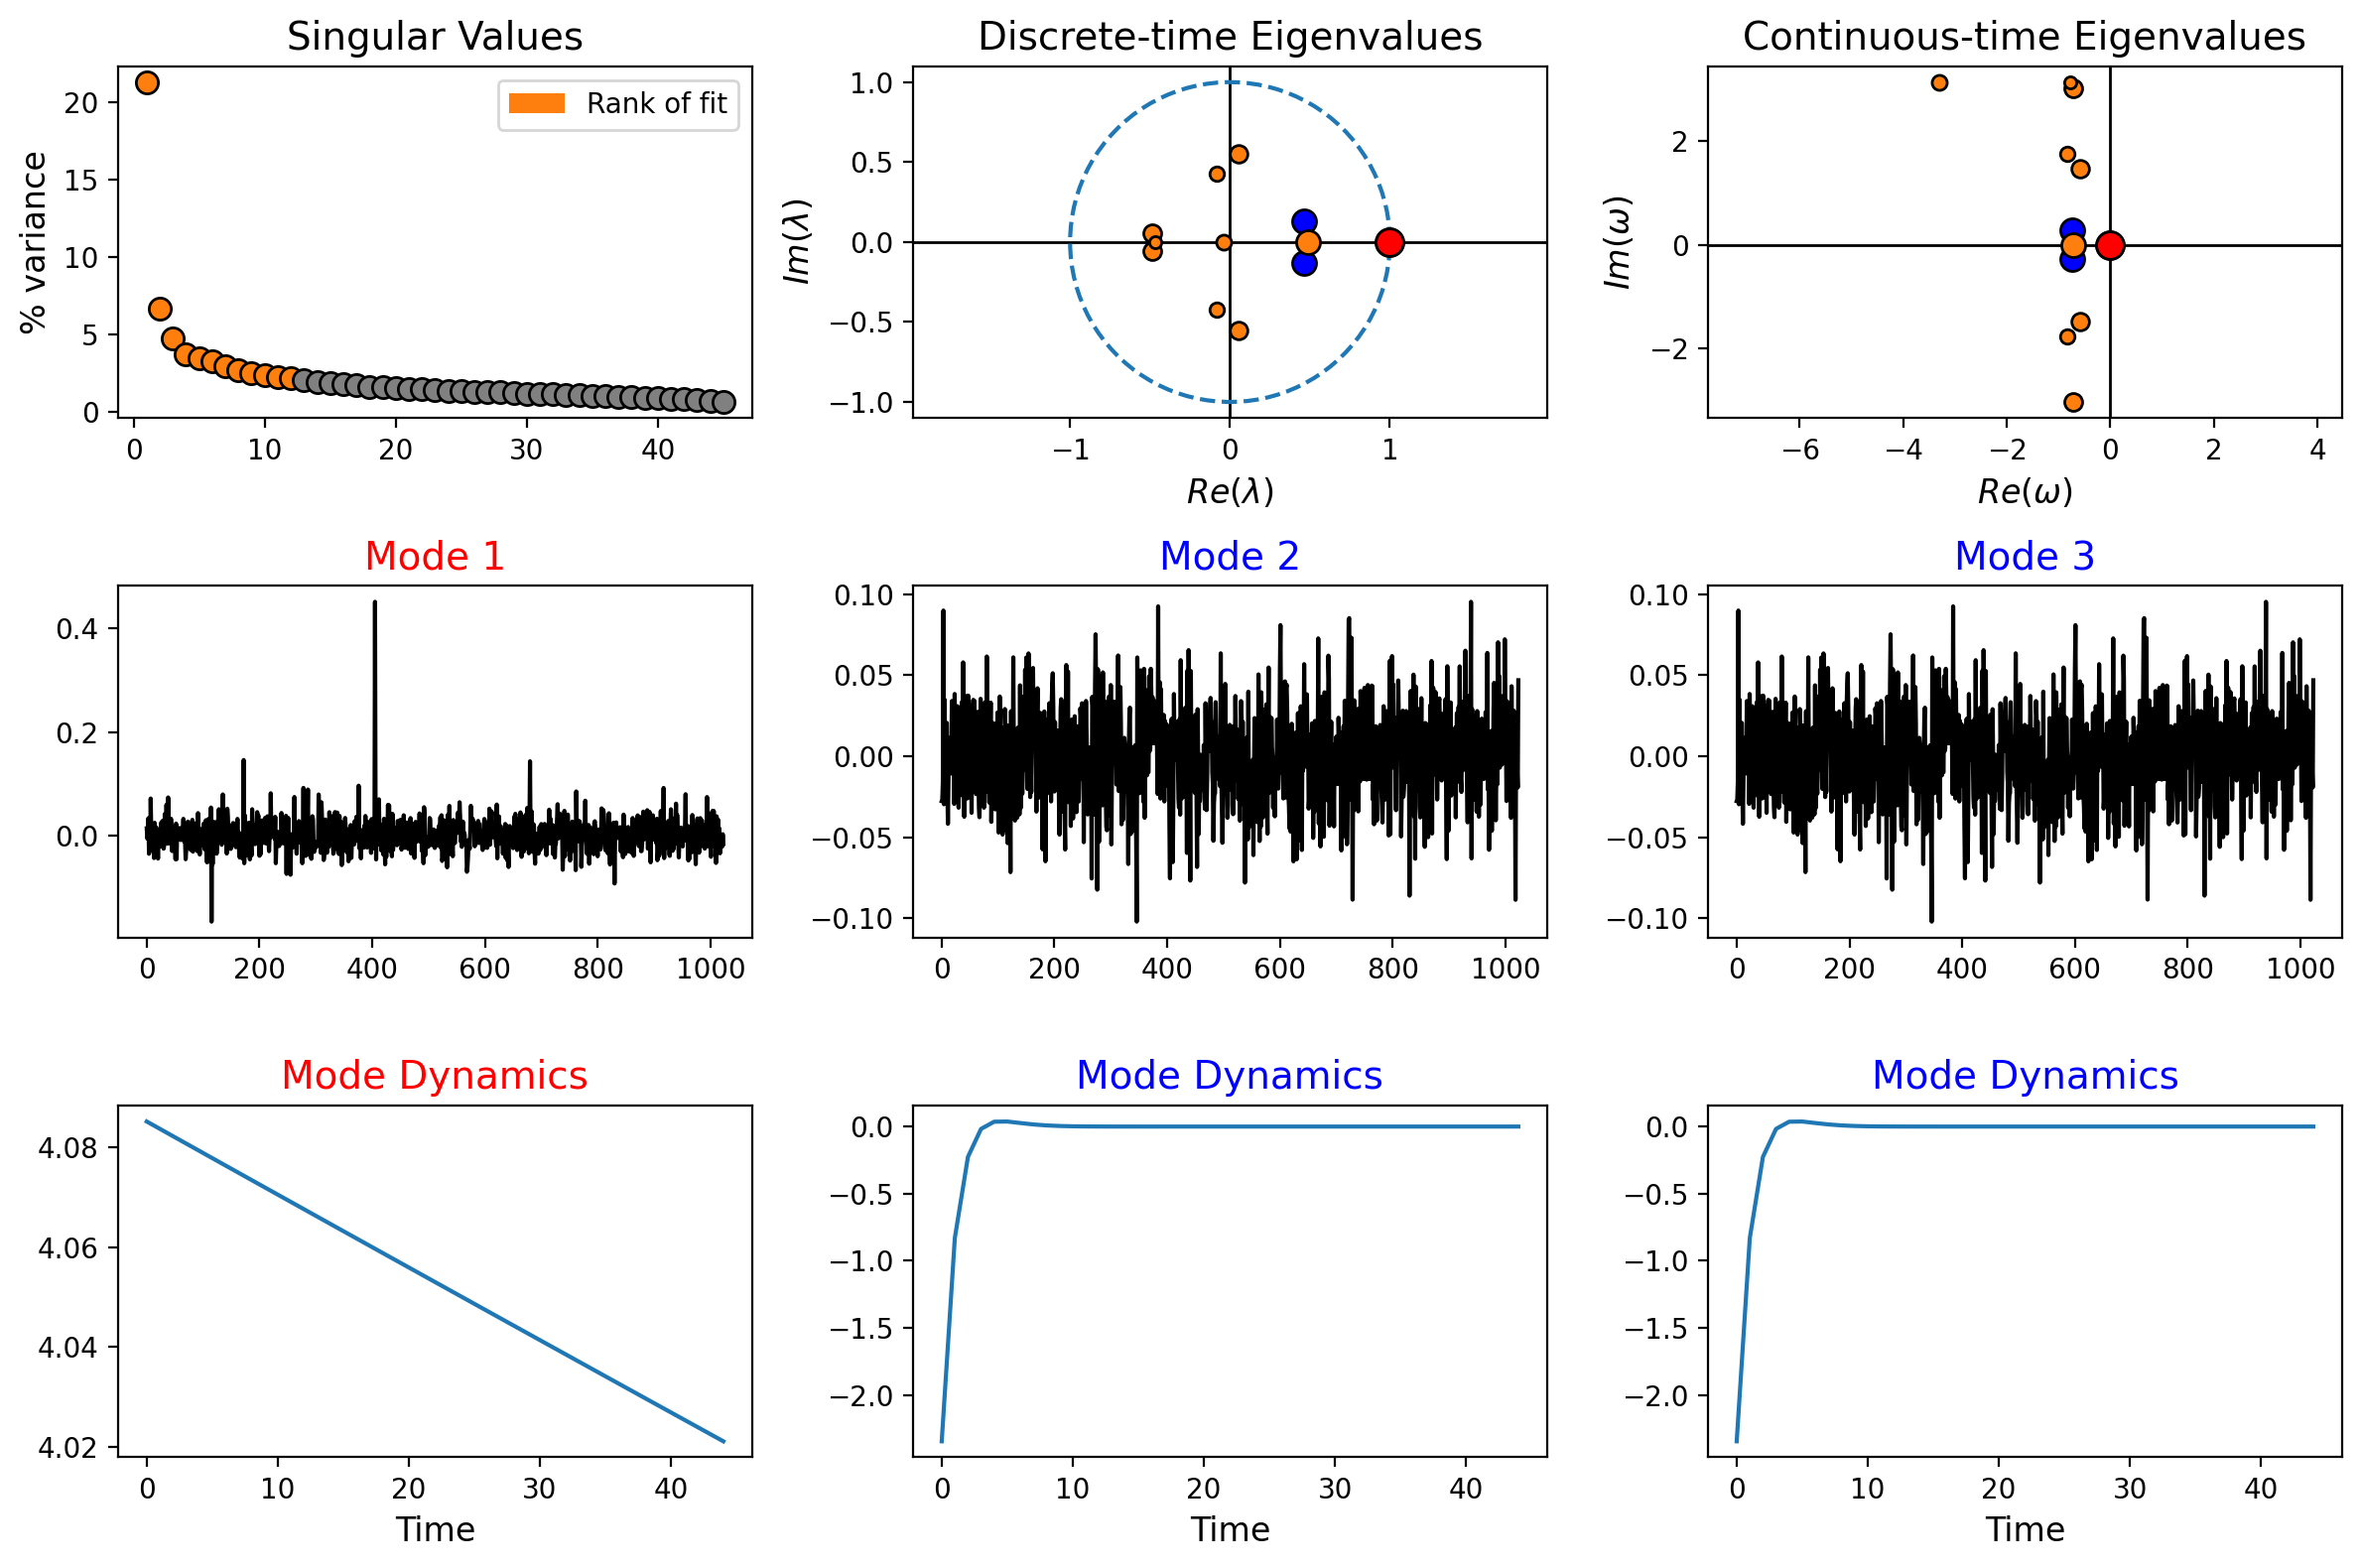

In [16]:
plot_summary(dmdT)

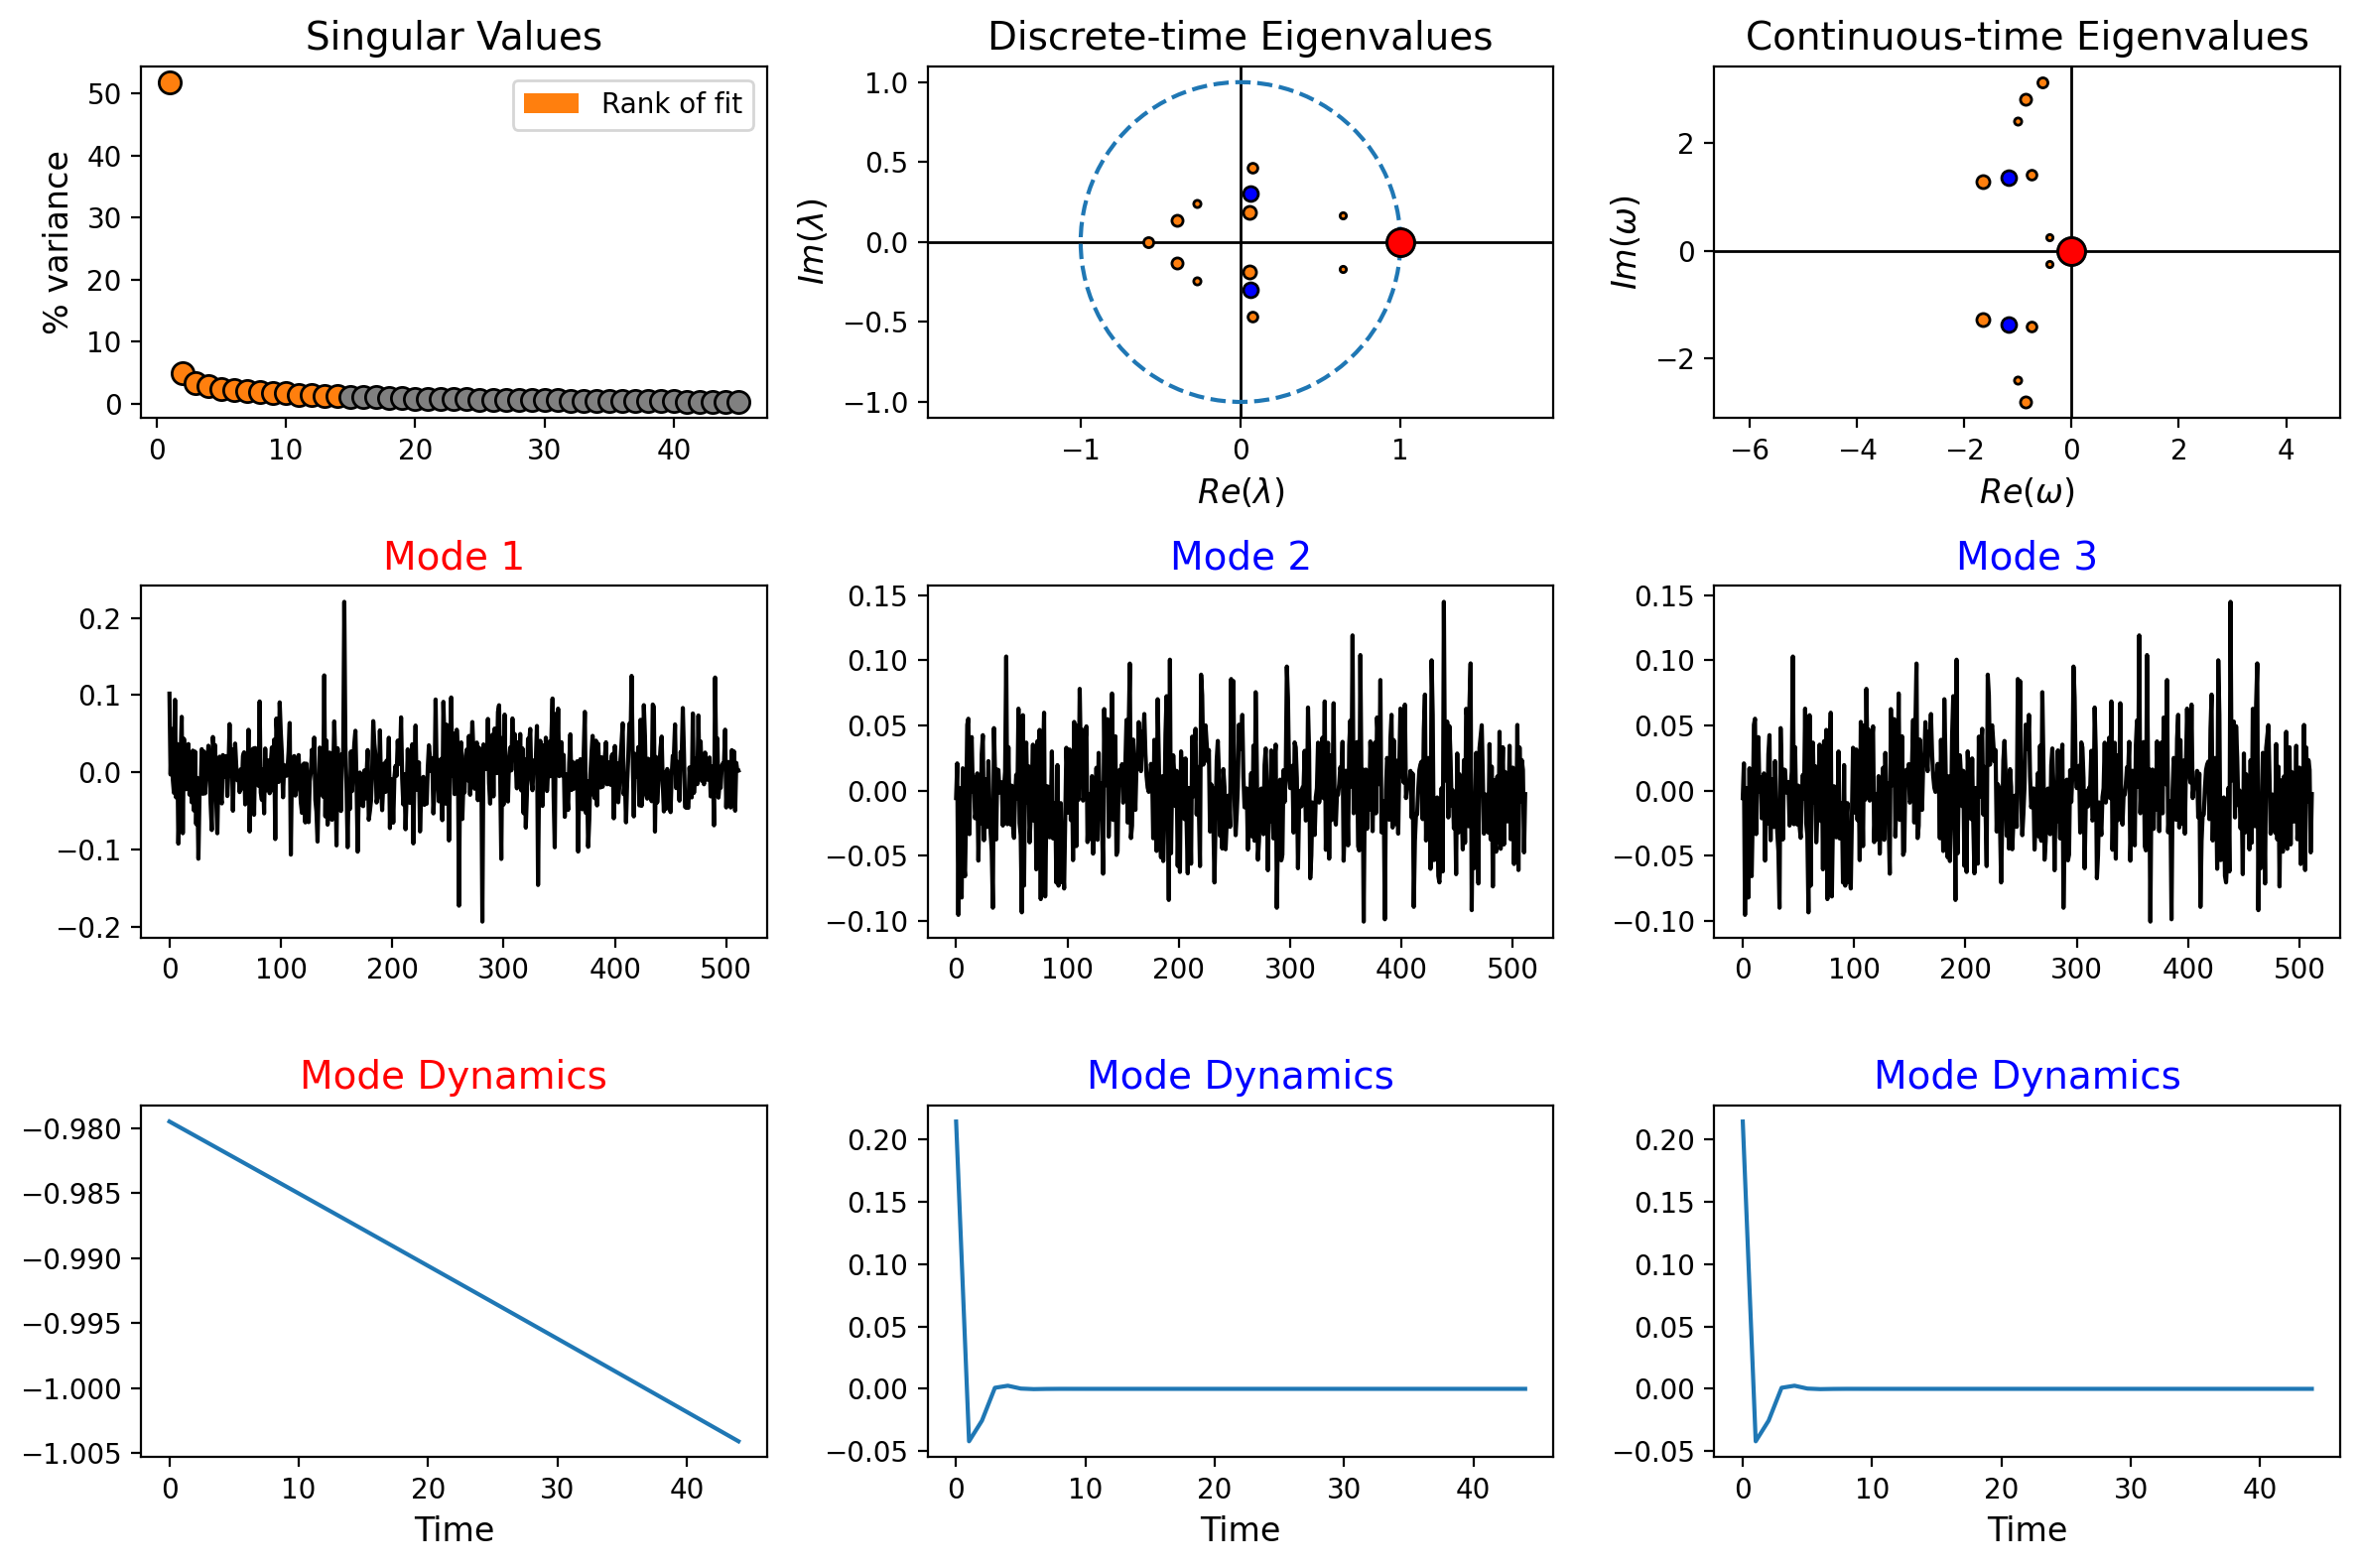

In [17]:
plot_summary(dmdS)